# Acquisition functions
PyAL makes use of so-called acquisition functions. After a model is fitted, the acquisition function is calculated for all potential data points which are not evaluated yet. Then the maxima of the acquisition function tell the program which data points should be added to the data set within the Active Learning process.
Basically, PyAL uses a 5-step scheme:
1. Fit a model
2. Calculate the acquisition function based on the models prediction and find its maximum
3. Calculate the true value for the data point with the (global) maximum
4. Add the data point to the data set
5. Repeat 1-4

You repeat this until you are satisified with the accuracy of the model or until you have picked a maximum number of data points.
Batch-wise learning is realized as the following:
1. Fit a model
2. Calculate the acquisition function based on the models prediction and find its maximum
3. Assume that the true value of the data point with the (global) maximum is equal to the models prediction
4. Add the data point to the data set and mark it as approximated
5. Repeat 1-4 until you have added the desired number of data points in your batch
6. Calculate the true value for all data points marked as approximated and change the values accordingly. 
7. Repeat 1-6

Again, you repeat this scheme until you are satisfied with the accuracy of the model or until you have picked a maximum number of data points or batches. 

PyAL provides a number of different acquisition functions mainly taken from [1](https://doi.org/10.1016/j.ins.2018.09.060) and [2](https://doi.org/10.1016/j.ins.2023.01.028) for optimizing the whole model. 
Furthermore, acquisition functions known from Bayesian Optimization are implemented which can be used to find the maximum of a function quickly.

The following acquisition functions are implemented:

1. GSx [[1](https://doi.org/10.1016/j.ins.2018.09.060)]
2. GSy [[1](https://doi.org/10.1016/j.ins.2018.09.060)]
3. iGS [[1](https://doi.org/10.1016/j.ins.2018.09.060)]
4. IDEAL [[2](https://doi.org/10.1016/j.ins.2023.01.028)]
5. UCB - Upper Confidence Bound [[3](https://ekamperi.github.io/machine%20learning/2021/06/11/acquisition-functions.html)]
6. POI - Probability of Improvement [[3](https://ekamperi.github.io/machine%20learning/2021/06/11/acquisition-functions.html)]
7. EI - Expected Improvement [[3](https://ekamperi.github.io/machine%20learning/2021/06/11/acquisition-functions.html)]
8. QBC - Query by Commitee
9. std - Standard deviation
10. UIDAL - self-designed: Using parts of IDEAL + std
11. SGSx - self-designed: Weighted GSx + std


Note that there are different implementations of acquisition functions available, either desired for calculating the acquisition function for all data points in a pool (acfn_discrete module) or for finding the maximum of the acquisition function together with global optimization routines (acfn_continuous module).

Not all acquisition functions can be used with all scikit-learn model types. All models requiring an uncertainty or standard deviation can only be used with Gaussian Process Regression models in this version of code. 

## Description of some acquisition functions
For functions not described here or for further information please see the references.

### UCB
The Upper Confidence Bound is given as
$$
UCB = \mu + \lambda\sigma
$$
where $\mu$ is the predicted value for a data point and $\sigma$ is the uncertainty. $\alpha$ is a weighting factor.

### POI
The Probability of Improvement is given as
$$
POI = \Phi\left(\frac{\mu - f_\mathrm{max} - \alpha}{\sigma}\right)
$$
where $f_\mathrm{max}$ is the maximum value of the function found so far, $\alpha$ is an hyperparameter which can be used to adjust the maximum and enforce more exploration or exploitation in this way. $\Phi$ is the cummulative distribution function given as $\Phi(x) = P(X \leqslant x)$.

### EI
The Expected Improvement is given as
$$
EI = (\mu-f_\mathrm{max}-\alpha) \Phi\left(\frac{\mu - f_\mathrm{max} - \alpha}{\sigma}\right) + \sigma\Theta\left(\frac{\mu - f_\mathrm{max} - \alpha}{\sigma}\right)
$$
where $\Theta$ is the probability density function. If the hyperparameter $\alpha>0$ the algorithm tends toward more exploration instead of exploitation by assuming a larger maximum than actually found.

Note that POI and EI can also be formulated as a minimization problem instead of a maximization problem when searching for the minimum of a function.

### QBC
A number of $\alpha$ models is trained. Data points where the models disagree most are selected for adding to the data set.

### Standard deviation
Uses the standard deviation $\sigma$ predicted by GPR models.

### UIDAL
The UIDAL function is given as:
$$
UIDAL = \sigma + \alpha Z 
$$
where Z is taken from the IDEAL algorithm.

### SGSx
The SGSx function is given as 
$$
SGSx = \sigma^\alpha + GSx^{1-\alpha}
$$
with a hyperparameter $0\leqslant\alpha\leqslant1$.

## Custom acquisition functions
Currently it is not possible to use custom acquisition functions for nearly all active learning routines. There is an experimental feature which allows custom acquisition functions in the `run_continuous_batch_learning` function. 
Just provide a callable as the acquisition function and provide the custom_acfn_list as a further parameter.

This is a list of arguments which the custom acquisition function takes as input. It is important that the callable takes the arguments in the described order. The arguments must also be named as described here:

- x0: First argument, does not need to appear in this list.
- x: Values of the features of all evaluated samples
- y: Objective values of all evaluated samples
- max_y: Maximum observed value of all evaluated samples regression_model: sklearn model used for the fitting
- lim: boundary 
- alpha: hyperparameter
- poly_x: sklearn poly_transformer. Must be given if a linear regression model should be used with the acquisition function

The callable must return the value of the acquisition function as a float or as a numpy_array of floats.
In the example below, we show how a custom acquisition function can be used. We just take a similar example as in the Introduction notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PyAL.models import inv_sphere
from PyAL.optimize import run_continuous_batch_learning

from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

from scipy.stats import norm

random_state=41

Disabled warnings


In [2]:
#Parameters for grid
grid_size = 100     #Number of data points per dimension
dimensions = 1      #Number of dimensions
lim = [[-2,],[2,]]  #Bounds for each dimension. First lower bounds, than upper bounds

#Create a grid for arbitrary number of dimensions
x = []
[x.append(np.linspace(lim[0][i],lim[1][i], grid_size )) for i in range(dimensions)]
pool = np.meshgrid(*x)
pool = np.array(pool).T
test_pool = pool.reshape(grid_size**dimensions, dimensions)

#Data model
data_model = inv_sphere(d=dimensions, random_state=random_state)
noise = np.sqrt(1e-6)

#Regression model
kernel = RBF(length_scale=1, length_scale_bounds=[0.05,100])+WhiteKernel()
regression_model = GPR(kernel)

#Active Learning parameters
initial_samples=5  #Number of initial data points 
max_samples=12     #Number of data points that are maximally acquired 
batch_size=1        #Collect data points in batches of five before evaluating the model with a test data set
n_repetitions=1     #Repeat the active learning only once
  
initialization_method = 'random'   #Algorithm to collect initial data
optimization_method = 'PSO'        #Algorithm to search for the maximum of the acquisition function. Choose from 'PSO' or 'lbfgs'AttributeError
n_jobs = 1                         #Number of jobs to start for parallel computing

pso_options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'p':10*dimensions, 'i':50}  #Options for particle swarm optimization

active_learning_steps = int((max_samples-initial_samples)/batch_size) #Number of AL steps is calculated automatically

Now, we can define our own acquisition function. Here, we just use the basic Expected Improvement function for illustration purposes.

In [3]:
custom_acfn_input = ['regression_model', 'max_y', 'alpha'] #Here are all arguments listet that EI_con takes as input

#This is the expected Improvement acquisition function
def EI(x, regression_model, max_y, alpha=0):
    if len(x.shape) == 1:
        x = x.reshape(1,-1)
    mean, uncertainty = regression_model.predict(x, return_std=True)
    f_max = max_y
    cdf = norm.cdf((mean-f_max-alpha)/uncertainty)
    pdf = norm.pdf((mean-f_max-alpha)/uncertainty)
    ei = (mean-f_max-alpha)*cdf + uncertainty*pdf
    return -ei

Then, we just run the Active Learning (or Bayesian Optimization in the case of EI) with our custom acquisition function.

In [4]:
samples, result = run_continuous_batch_learning(data_model, 
            regression_model,
            acquisition_function = EI,
            opt_method = optimization_method,
            pool = test_pool, 
            batch_size=batch_size,
            noise=noise,
            initial_samples=initial_samples, 
            active_learning_steps=active_learning_steps,
            lim=lim,
            alpha=0,
            n_jobs=n_jobs,
            random_state=random_state,
            calculate_test_metrics=True,
            initialization=initialization_method,
            pso_options=pso_options,
            custom_acfn_input=custom_acfn_input
            )


Using a custom acquisition function. This is an experimental feature. Please be careful.


And finally, we plot the results of our Bayesian Optimization.

Text(0, 0.5, 'y')

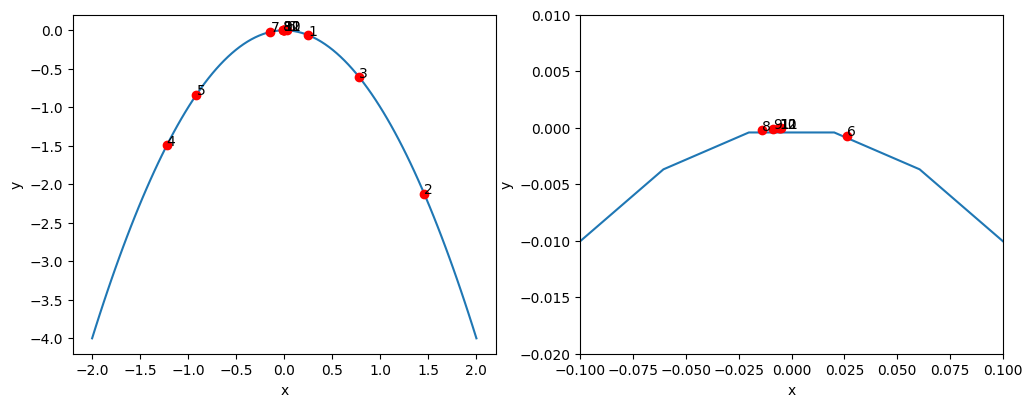

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4.4))
ax1.plot(test_pool, data_model.evaluate(test_pool))
ax2.plot(test_pool, data_model.evaluate(test_pool))

x_s = samples
y_s = data_model.evaluate(samples)

ax1.plot(x_s, y_s, 'ro')
for txt in range(len(x_s)):
    ax1.annotate(txt+1, (x_s[txt], y_s[txt]))
ax2.plot(x_s, y_s, 'ro')
for txt in range(len(x_s)):
    ax2.annotate(txt+1, (x_s[txt], y_s[txt]))
ax2.set_xlim(-0.1, 0.1)
ax2.set_ylim(-0.02, 0.01)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax2.set_xlabel('x')
ax2.set_ylabel('y')

Side note: If you want to use an already implemented acquisition function in PyAL, just provide the corresponding string as the `acquisition_function` parameter.

[1] Wu, D.; Lin, C.-T.; Huang, J. Information Sciences 2019, 474, 90–105., doi: https://doi.org/10.1016/j.ins.2018.09.060. <br>
[2] Bemporad, A. Information Sciences 2023, 626, 275–292.,doi: https://doi.org/10.1016/j.ins.2023.01.028. <br>
[3] https://ekamperi.github.io/machine%20learning/2021/06/11/acquisition-functions.html